In [1]:
import numpy as np
t = np.transpose
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import nltk

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler
!pip install gensim 
import gensim
from gensim.models.keyedvectors import KeyedVectors
import seaborn as sns; sns.set(color_codes=True)
import math
import random 

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [3]:
def do_plot(X_fit, title=None, labels=['']):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    
    # print(X_fit.shape, label_types, num_labels, colors)
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            
            for lab, col in zip(label_types, colors):
                if num_labels>1:
                    idxs = [i for i,v in enumerate(labels) if v == lab]
                    ax.scatter([X_fit[i, 0] for i in idxs],
                               [X_fit[i, 1] for i in idxs],
                               c=col, label=lab)
                else:
                    ax.scatter(X_fit[:, 0],
                               X_fit[:, 1],
                               c=col)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        if num_labels>1:
            ax.legend()
        plt.show()

In [4]:
def load_in(name): 
    out = [] 
    with open('gender_list/' + name + '.txt', 'r') as f:
        out = f.read().splitlines()
    return out 

cmu_female = load_in('cmu_female')
cmu_male = load_in('cmu_male')
zhao_female = load_in('female_zhao')
zhao_male = load_in('male_zhao')

gender_list = list(set(cmu_female + cmu_male + zhao_female + zhao_male))
print('gender_list length: ', len(gender_list))

gender_list length:  7990


In [5]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
      return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
      return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [6]:
def post_process_cn(embd, word_list, alpha = 2):
    print("starting...")
    
    #Calculate the correlation matrix
    R = np.corrcoef(embd)
    print('R done')
    
    #Calculate the conceptor matrix
    C = R @ (np.linalg.inv(R + alpha ** (-2) * np.eye(embd.shape[0])))
    print('C done')
    
    #Calculate the negation of the conceptor matrix
    negC = np.eye(embd.shape[0]) - C
    print('negC done')
  
    #Post-process the vocab matrix
    newX = negC @ embd
    print('newX done')
    
    return newX

In [57]:
# test word list 
chk_male_terms = ['brother', 'father', 'grandfather', 'son', 'he', 'his', 'him', 'husband', 'man']
chk_female_terms = ['sister', 'mother', 'grandmother', 'daughter', 'she', 'hers', 'her', 'wife', 'woman']
chk_neut_terms = ['sibling', 'parent', 'grandparent', 'child', 'they', 'theirs', 'them', 'spouse', 'human']

chk_gendered_terms = chk_male_terms + chk_female_terms
L = len(chk_male_terms)

chk_terms = []
for i in range(L): 
    m = chk_male_terms[i]
    f = chk_female_terms[i]
    n = chk_neut_terms[i]
    chk_terms.append(m)
    chk_terms.append(f)
    chk_terms.append(n)

print(len(chk_terms))

27


In [64]:
word_list = [] 
for w in gender_list: 
    if w not in chk_terms: 
        word_list.append(w)

word_list = chk_terms + word_list
print(len(chk_terms))
print(len(word_list))



27
7999


In [94]:
W_1_Pleasant = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
W_1_Unpleasant = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison']

random.shuffle(W_1_Pleasant)
random.shuffle(W_1_Unpleasant)

pleasant_list = W_1_Pleasant[0:2]
unpleasant_list = W_1_Unpleasant[0:2]

p_unp_list = pleasant_list + unpleasant_list
print('target words used: ', pleasant_list)
print('unpleasant words used: ', unpleasant_list)


target words used:  ['diamond', 'paradise']
unpleasant words used:  ['stink', 'divorce']


In [59]:
target_list = word_list + pleasant_list + unpleasant_list


# Non-contextualized - Word2Vec & Glove 

In [9]:
!pip install -q gdown

In [9]:
!gdown https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
To: /Users/lisazhao/Desktop/Research/gensim_glove.840B.300d.txt.bin
2.65GB [01:41, 26.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /Users/lisazhao/Desktop/Research/GoogleNews-vectors-negative300.bin.gz
1.65GB [01:06, 24.7MB/s]


In [10]:
glove = KeyedVectors.load_word2vec_format('/Users/lisazhao/Desktop/Research/gensim_glove.840B.300d.txt.bin', binary=True)
print('The glove embedding has been loaded!')

Word2Vec = KeyedVectors.load_word2vec_format('/Users/lisazhao/Desktop/Research/GoogleNews-vectors-negative300.bin.gz', binary=True)
print('The Google News Word2Vec embedding has been loaded!')


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The glove embedding has been loaded!


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The Google News Word2Vec embedding has been loaded!


In [11]:
def pick_embedding(word_list, model): 
    mdl = eval(model)
    out = [] 
    labels = [] 
    missing_words = []
    for word in word_list: 
        if word in mdl.vocab: 
            embd = mdl[word]
            out.append(embd)
            labels.append(word)
        else: 
            missing_words.append(word)
    out = np.asarray(out)
    print(model, 'missing ', len(missing_words), 'words from the word list') 
    return (out, labels)
        

In [66]:
w2v_embd, w2v_labels = pick_embedding(word_list, 'Word2Vec')
glove_embd, glove_labels = pick_embedding(word_list, 'glove')

# w2v_neu_embd, w2v_neu_labels = pick_embedding(chk_neut_terms, 'Word2Vec')
# glove_neu_embd, glove_neu_labels = pick_embedding(chk_neut_terms, 'glove')

w2v_target_embd, w2v_target_labels = pick_embedding(target_list, 'Word2Vec')
glove_target_embd, glove_target_labels = pick_embedding(target_list, 'glove')



Word2Vec missing  874 words from the word list
glove missing  721 words from the word list
Word2Vec missing  874 words from the word list
glove missing  721 words from the word list


In [61]:
print('w2v: ', w2v_embd.shape)
print('glove: ', glove_embd.shape)

w2v:  (7125, 300)
glove:  (7278, 300)


## 1. No scaling of word embeddings 

### - W2V

##### Compare to neutral words 

In [51]:
def project_embd(target_word_embds, pc1, pc2): 
    pass 
    

In [73]:
print(w2v_labels[0:27])
L

['brother', 'sister', 'sibling', 'father', 'mother', 'parent', 'grandfather', 'grandmother', 'grandparent', 'son', 'daughter', 'child', 'he', 'she', 'they', 'his', 'hers', 'theirs', 'him', 'her', 'them', 'husband', 'wife', 'spouse', 'man', 'woman', 'human']


9

In [120]:
def neu_pc_plot(embd, label, mdl, scale = 'no', debiased = 'no'):
    PC = PCA(n_components=2).fit_transform(embd)
    L = len(label)
    data = PC[0:L, :]
    
    # sns.set_style('ticks')
    p1 = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
    p1.figure.set_size_inches(15, 12)
    sns.despine()
    
    # add annotations one by one with a loop
    for line in range(L):
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, label[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')
        
    # draw line among pairs 
    colors = sns.cubehelix_palette(9)
    for i in range(int(L/3)): 
        p1.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
        p1.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
        p1.arrow(data[3*i+2,0], data[3*i+2,1], 
                 data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
                 head_width=0.01, head_length=0.01, 
                 fc='orange', ec=colors[i])
    
        p1.arrow(data[3*i+2,0], data[3*i+2,1], 
                 data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
                 head_width=0.01, head_length=0.01, 
                 fc='orange', ec=colors[i])
 
    # titles 
    title = mdl + ', ' + scale + ' scaling' + ', ' + debiased +' debiasing'
    p1.set_title(title, fontsize=20)
    p1.set_xlabel('PC1', fontsize=20) 
    p1.set_ylabel('PC2', fontsize=20)

In [122]:
def neu_pc_plot_data(embd, label, mdl, scale = 'no', debiased = 'no'):
    PC = PCA(n_components=2).fit_transform(embd)
    L = len(label)
    data = PC[0:L, :]
    return data 

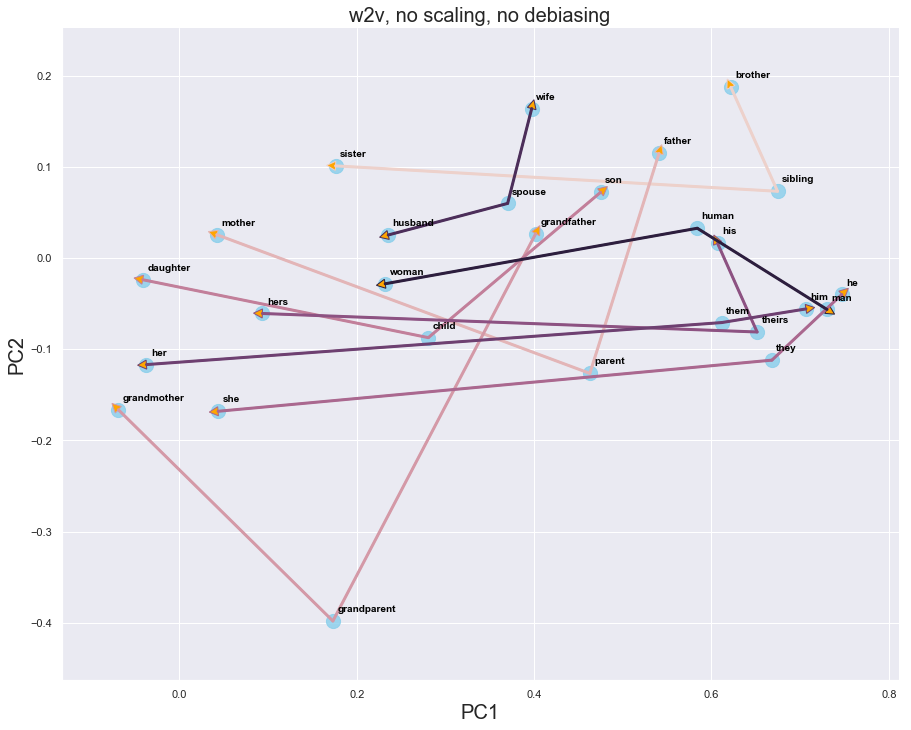

In [175]:
neu_pc_plot(w2v_embd, chk_terms, mdl = 'w2v', scale = 'no', debiased = 'no')

In [124]:
def neu_get_cos_sim(data): 
    cosine = [] 
    for i in range(int(data.shape[0]/3)): 
        v1 = [data[3*i,0] - data[3*i+2,0], 
              data[3*i,1] - data[3*i+2,1]]
        v2 = [data[3*i+1,0] - data[3*i+2,0], 
              data[3*i+1,1] - data[3*i+2,1]]
        cos = dotproduct(v1, v2)/length(v1)/length(v2)
        cosine.append(cos)
    print('cosine similarities: ', cosine)
    return cosine 

cosine similarities:  [0.46898531692428996, 0.0343344704118299, 0.2666794304520656, -0.6356961991025878, -0.7956301932432129, 0.4495218700725358, -0.996355279544098, -0.4854758020770617, -0.7531024906666194]


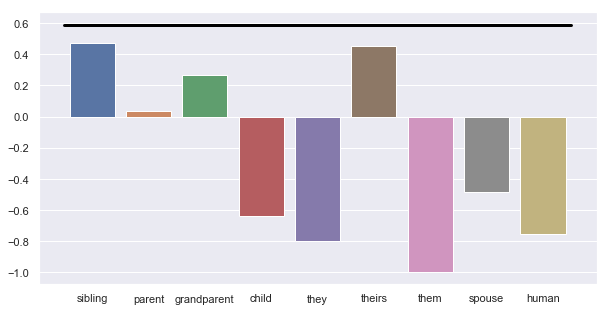

In [125]:
ax = sns.barplot(x=chk_neut_terms, y=neu_get_cos_sim(neu_pc_plot_data(w2v_embd, chk_terms, mdl = 'w2v', scale = 'No', debiased = 'no')))
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

In [128]:
def tar_pc_plot(embd, label, target_label, mdl, scale = 'no', debiased = 'no'):
    PC = PCA(n_components=2).fit_transform(embd)
    L = len(label)
    T = len(target_label)
    data = np.concatenate((PC[0:L, :], PC[-1*T:, :]), axis = 0) 
    
    # remove the neutral terms 
    idx = list(range(2,len(chk_terms),3))
    here_data = np.delete(data, idx, axis = 0)
    here_labels = label + target_label
    
    # sns.set_style('ticks')
    p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
    p1.figure.set_size_inches(15, 12)
    sns.despine()

    # add annotations one by one with a loop
    for line in range(len(here_labels)):
        # exclude neutral terms 
        if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
            pass 
        else: 
            p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                    horizontalalignment='left', size='medium', color='black', weight='semibold')

    # draw line among pairs 
    colors = sns.cubehelix_palette(9)
    for i in range(int(L/3)): 
        p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
    # titles 
    title = mdl + ', ' + scale + ' scaling' + ', ' + debiased +' debiasing'
    p1.set_title(title, fontsize=20)
    p1.set_xlabel('PC1', fontsize=20) 
    p1.set_ylabel('PC2', fontsize=20)
    

In [129]:
def tar_pc_plot_data(embd, label, target_label, mdl, scale = 'no', debiased = 'no'):
    PC = PCA(n_components=2).fit_transform(embd)
    L = len(label)
    T = len(target_label)
    data = np.concatenate((PC[0:L, :], PC[-1*T:, :]), axis = 0) 
    
    # remove the neutral terms 
    idx = list(range(2,len(chk_terms),3))
    here_data = np.delete(data, idx, axis = 0)
    here_labels = label + target_label
    
    return here_data, here_labels 
    

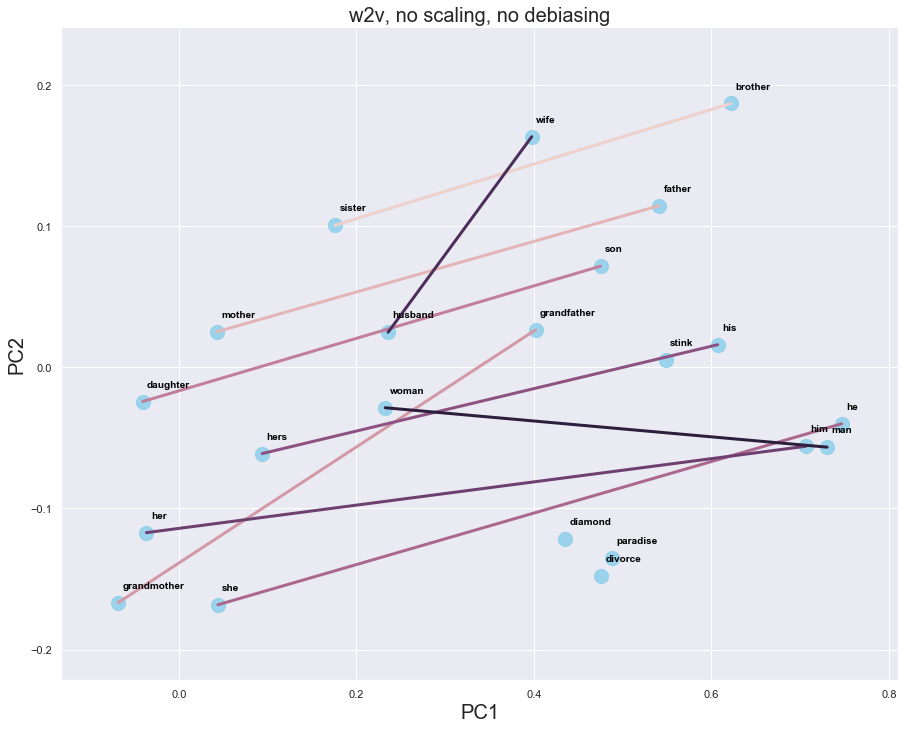

In [130]:
tar_pc_plot(w2v_target_embd, chk_terms, p_unp_list, mdl = 'w2v', scale = 'no', debiased = 'no')


In [162]:
def tar_get_cos_sim(data, label, target_label): 
    out_male = [] 
    out_female = [] 
    T = len(target_label)
    L = len(label) 
    
    for j in range(-1*T,0): # loop thru target words 
        female_dist = 0 
        male_dist = 0 
        this_target = target_label[j]
        this_target_embd = data[j,:]
        male_holder = [] 
        female_holder = [] 
        
        for i in range(int(L/2)): # loop thru each gender words 
            v_male = data[2*i, :]
            v_female = data[2*i+1, :]
            cos_male = dotproduct(v_male, this_target_embd)/length(v_male)/length(this_target_embd)
            male_holder.append(cos_male)
            
            cos_female = dotproduct(v_female, this_target_embd)/length(v_female)/length(this_target_embd)
            female_holder.append(cos_female)
            
        out_male.append(np.mean(male_holder))  
        out_female.append(np.mean(female_holder))  
    
    df = pd.DataFrame(out_male + out_female)
    df = pd.DataFrame({'cos_sim':out_male + out_female, 
                       'sex': ['male'] * T + ['female'] * T,
                       'label': target_label + target_label})
    
    g = sns.factorplot(x='label', y='cos_sim', hue='sex', data = df, kind='bar')
    g.set(ylim=(0, 1))
    diff = np.mean([a_i - b_i for a_i, b_i in zip(out_male, out_female)])
    print('difference of cosine similarity between male and female to target words: ', diff)
    return diff 


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


difference of cosine similarity between male and female to target words:  0.5416119585257907


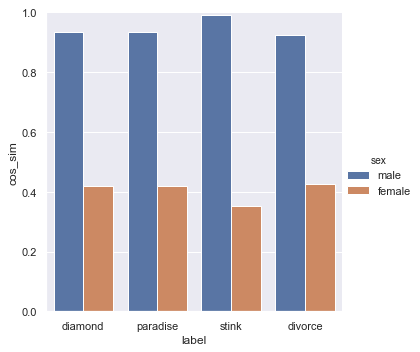

In [163]:
data = tar_pc_plot_data(w2v_target_embd, chk_terms, p_unp_list, mdl = 'w2v', scale = 'no', debiased = 'no')[0]
cos = tar_get_cos_sim(data, chk_gendered_terms, p_unp_list)

##### Apply CN 

In [153]:
w2v_embd_cn = post_process_cn(w2v_embd, w2v_labels)

starting...
R done
C done
negC done
newX done


In [170]:
w2v_target_embd_cn = post_process_cn(w2v_target_embd, w2v_target_labels) 

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

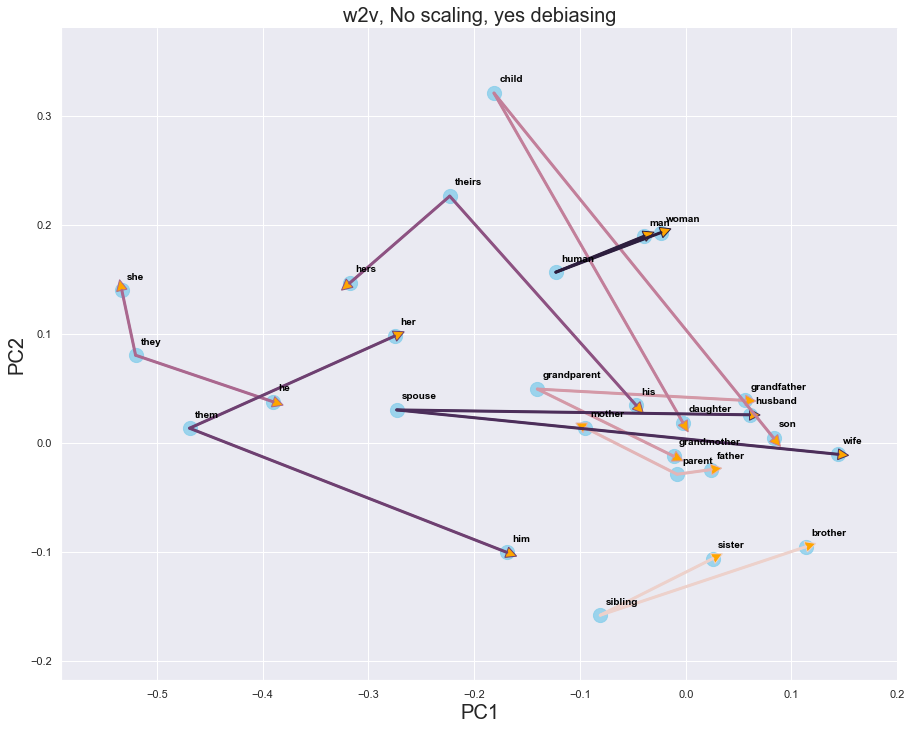

In [164]:
neu_pc_plot(w2v_embd_cn, chk_terms, mdl = 'w2v', scale = 'No', debiased = 'yes')

In [168]:
data = neu_pc_plot_data(w2v_embd_cn, chk_terms, mdl = 'w2v', scale = 'No', debiased = 'yes')

cosine similarities:  [0.9899892249078929, -0.8315163945737206, 0.9238959463436295, 0.9868378958660605, -0.5075155817860725, -0.042565938636443194, 0.7153312337443215, 0.9964915578056582, 0.9996669556363303]


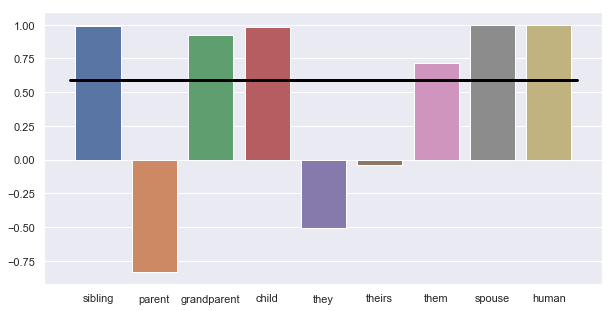

In [169]:
ax = sns.barplot(x=chk_neut_terms, y=neu_get_cos_sim(data))
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)

##### Compare to target words 

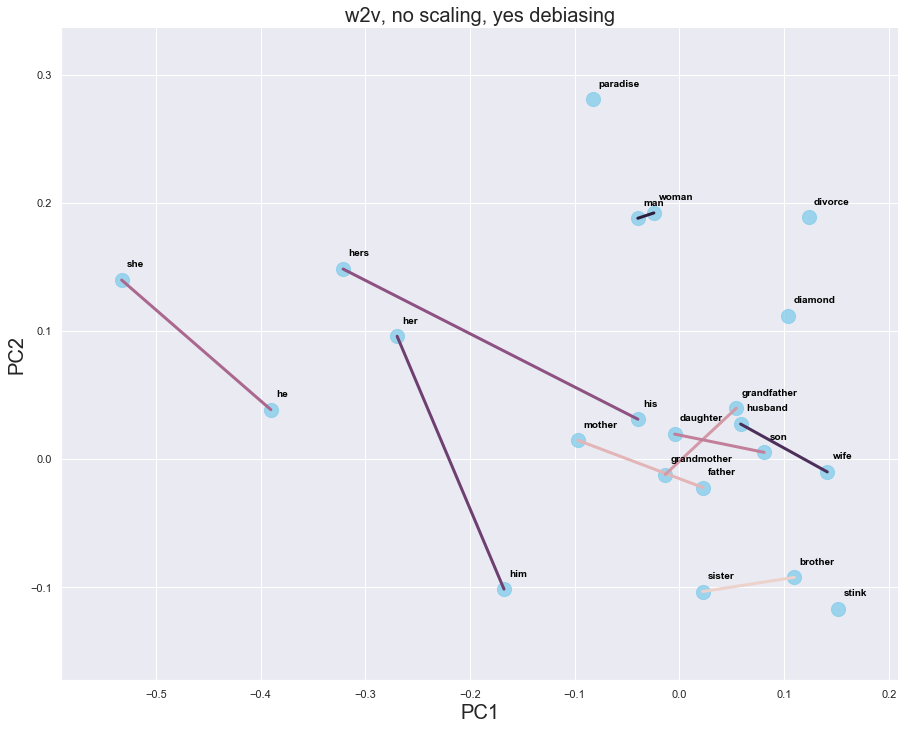

In [171]:
tar_pc_plot(w2v_target_embd_cn, chk_terms, p_unp_list, mdl = 'w2v', scale = 'no', debiased = 'yes')


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


difference of cosine similarity between male and female to target words:  0.21718074090975378


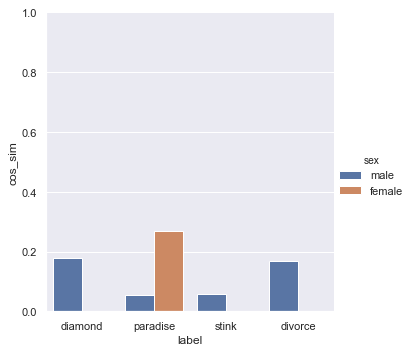

In [172]:
data = tar_pc_plot_data(w2v_target_embd_cn, chk_terms, p_unp_list, mdl = 'w2v', scale = 'no', debiased = 'yes')[0]
cos = tar_get_cos_sim(data, chk_gendered_terms, p_unp_list)

### - Glove

##### Compare to neutral words 

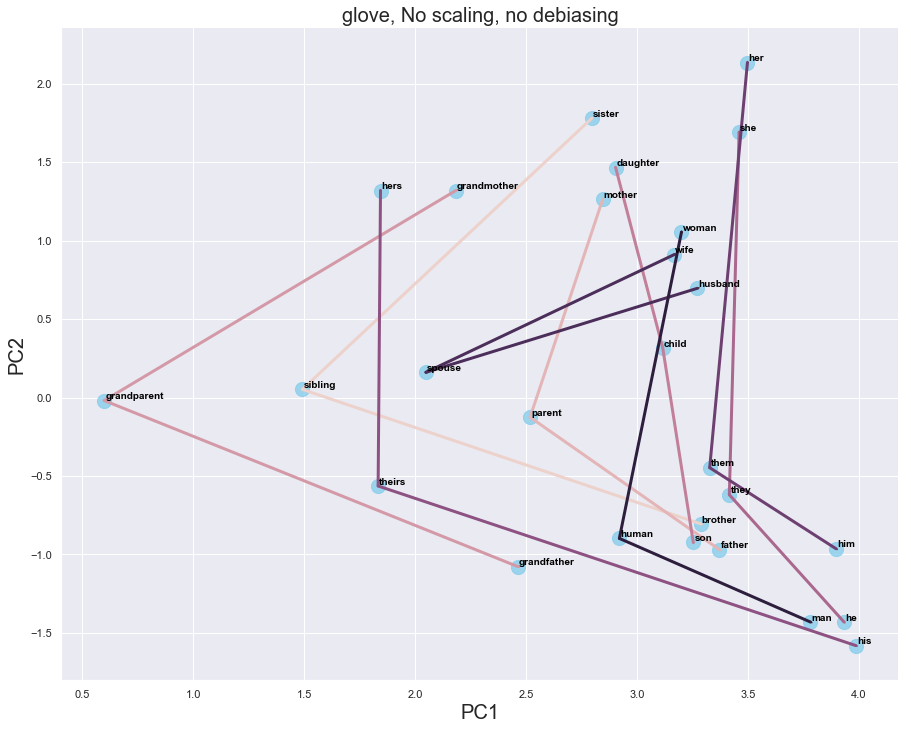

In [174]:
neu_pc_plot(glove_embd, chk_terms, mdl = 'glove', scale = 'No', debiased = 'no')

In [ ]:
ax = sns.barplot(x=chk_neut_terms, y=neu_get_cos_sim(neu_pc_plot_data(glove_embd, chk_terms, mdl = 'glove', scale = 'No', debiased = 'no')))
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


In [174]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.19972471293904664, 0.5218415928655898, 0.34551762103782313, 0.997309831469658, 0.8334835420511872, 0.9893297144338161, 0.6222022229180407, 0.9842351524257898, 0.40068681115830335]


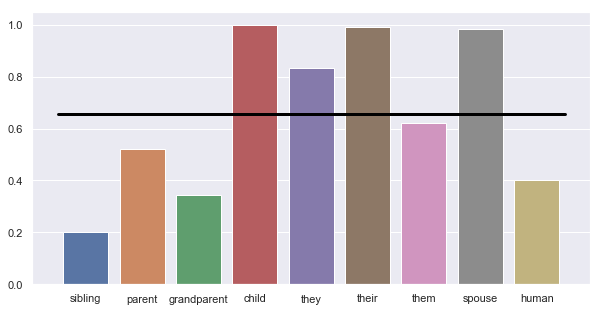

In [175]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

Text(0, 0.5, 'PC2')

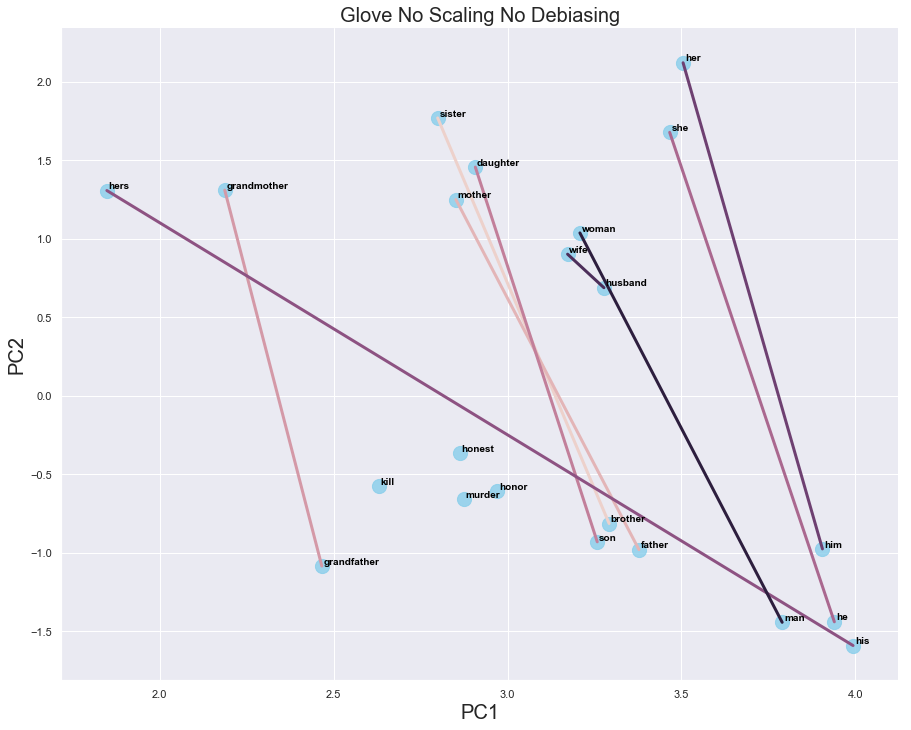

In [179]:
# basic plot
PC = PCA(n_components=2).fit_transform(glove_target_embd) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove No Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [180]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [1.0981688565678067, 0.9189868867397308, 1.1423449317614238, 0.9533228013250563]
female:  [1.8655489285786946, 2.0994162691964044, 2.0827999114990234, 2.1468859248691134]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


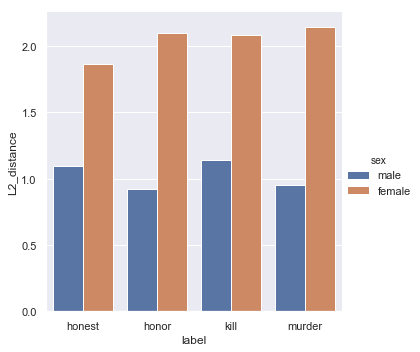

In [182]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
# g.set(ylim=(0, 0.7))

##### Apply CN 

In [38]:
glove_embd_cn = post_process_cn(glove_embd, glove_labels)

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

Text(0, 0.5, 'PC2')

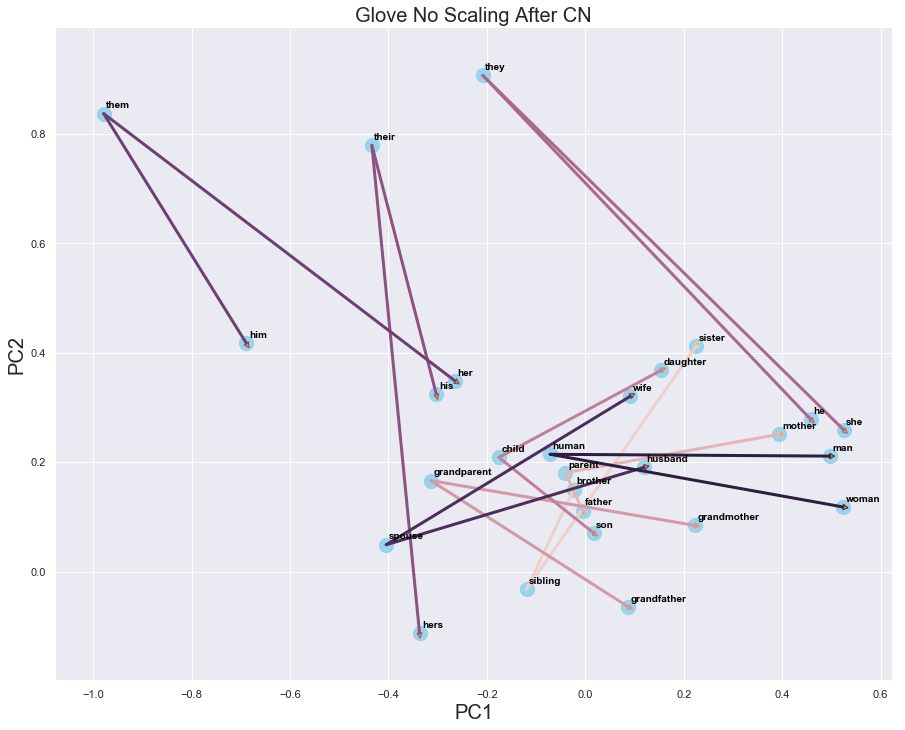

In [183]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(glove_embd_cn) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('Glove No Scaling After CN', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [184]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9845895170312888, 0.3015531753056935, 0.9321578010688449, 0.47810669291369523, 0.9994645095495721, 0.9852386069548981, 0.9336650217836684, 0.9720419925720558, 0.988082218472678]


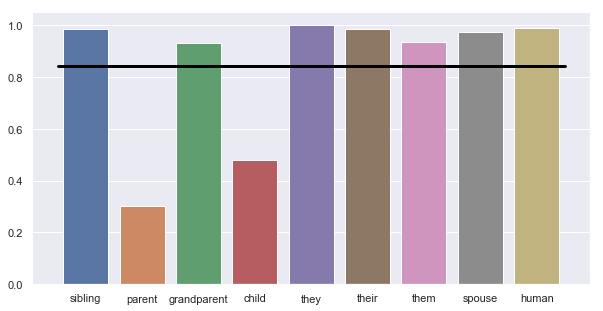

In [185]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

Text(0, 0.5, 'PC2')

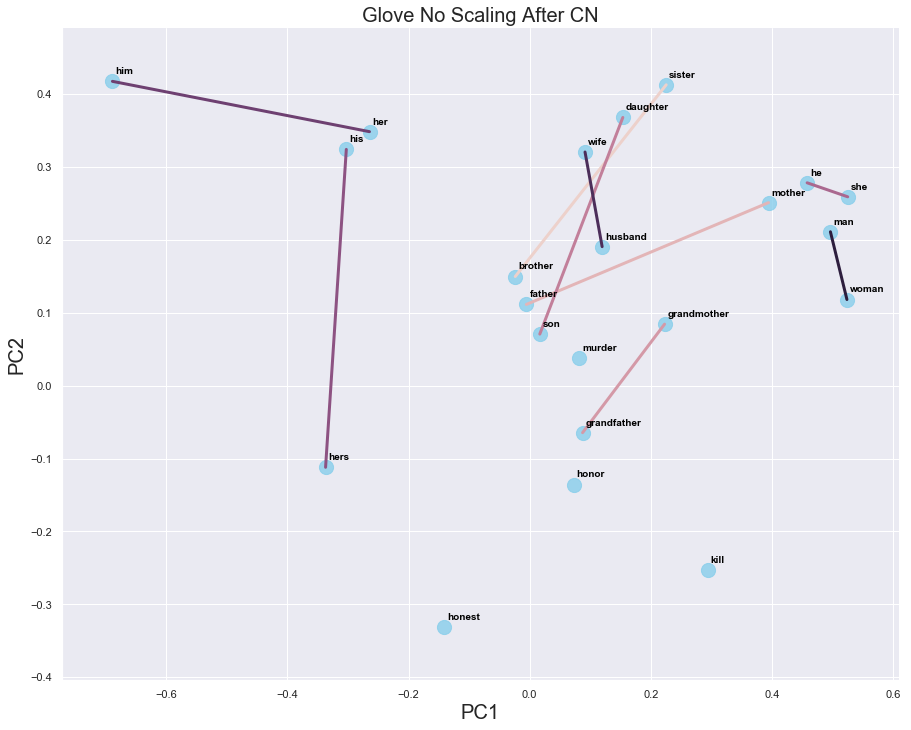

In [192]:
# basic plot
PC = PCA(n_components=2).fit_transform(glove_embd_cn) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove No Scaling After CN', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [193]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.6240281895200906, 0.42495281947999947, 0.5832474831911438, 0.3151140746270247]
female:  [0.6998148307743227, 0.4915241467215551, 0.5820464853646827, 0.3782851891917325]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


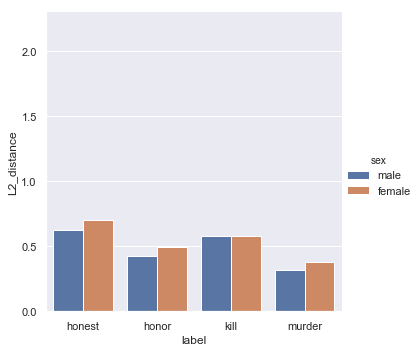

In [199]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 2.3))


## 2. Per feature standard scale word embeddings 

##### Compare to neutral words 

In [203]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
std_scale_w2v_embd = scaler.fit_transform(w2v_embd)

Text(0, 0.5, 'PC2')

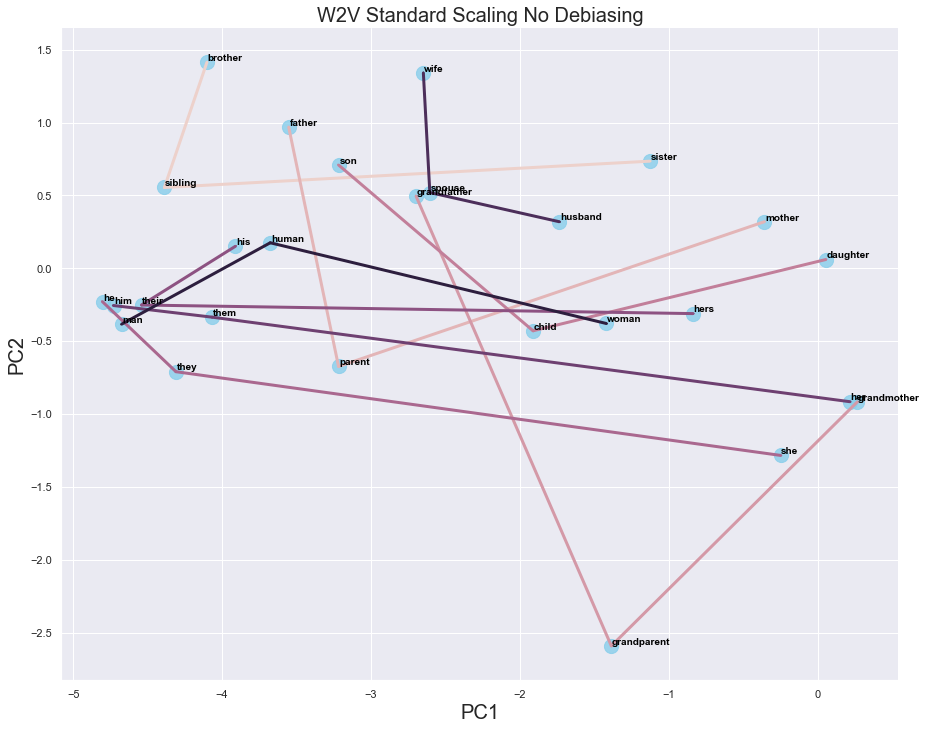

In [239]:
# basic plot
PC = PCA(n_components=2).fit_transform(std_scale_w2v_embd) 
data = PC[0:len(chk_terms), :]

# sns.set_style('ticks')
p1 = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [240]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.367650490053407, 0.13250784599237167, 0.3800691940106943, 0.5735110472629449, 0.8072370371901038, 0.8336926991470575, 0.9998935453607075, 0.27594664393285734, 0.731337636372343]


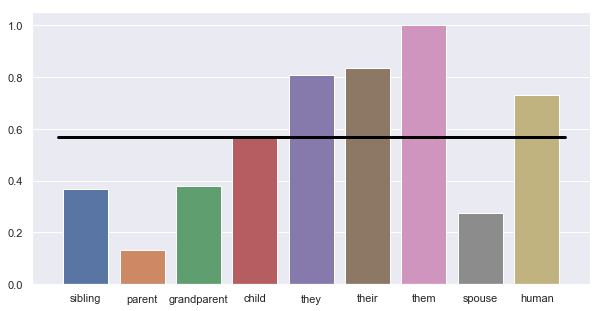

In [241]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

In [242]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
std_scale_w2v_target_embd = scaler.fit_transform(w2v_target_embd)

Text(0, 0.5, 'PC2')

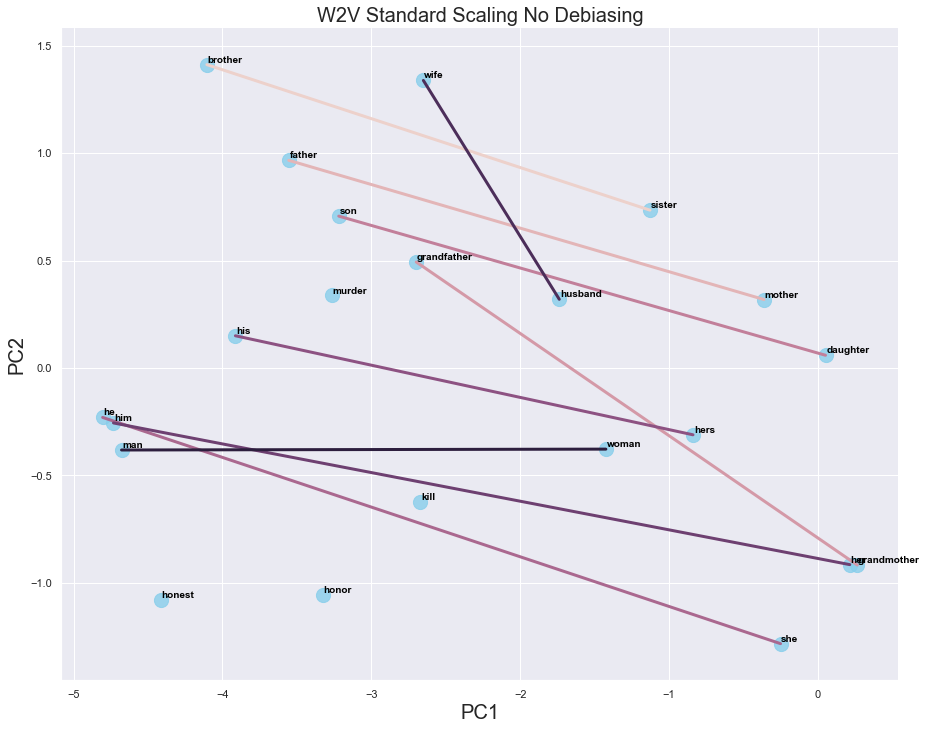

In [243]:
# basic plot
PC = PCA(n_components=2).fit_transform(std_scale_w2v_target_embd) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [244]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [1.7907299266921148, 1.8133798175387912, 1.7721888224283855, 1.1134676436583202]
female:  [3.983612749311659, 2.9980629020267062, 2.311422440740797, 2.7721265024609036]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


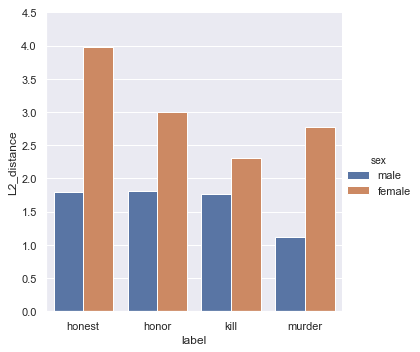

In [245]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 4.5))

##### Apply CN 

In [221]:
std_scale_w2v_embd_cn = post_process_cn(std_scale_w2v_embd, w2v_labels)

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

Text(0, 0.5, 'PC2')

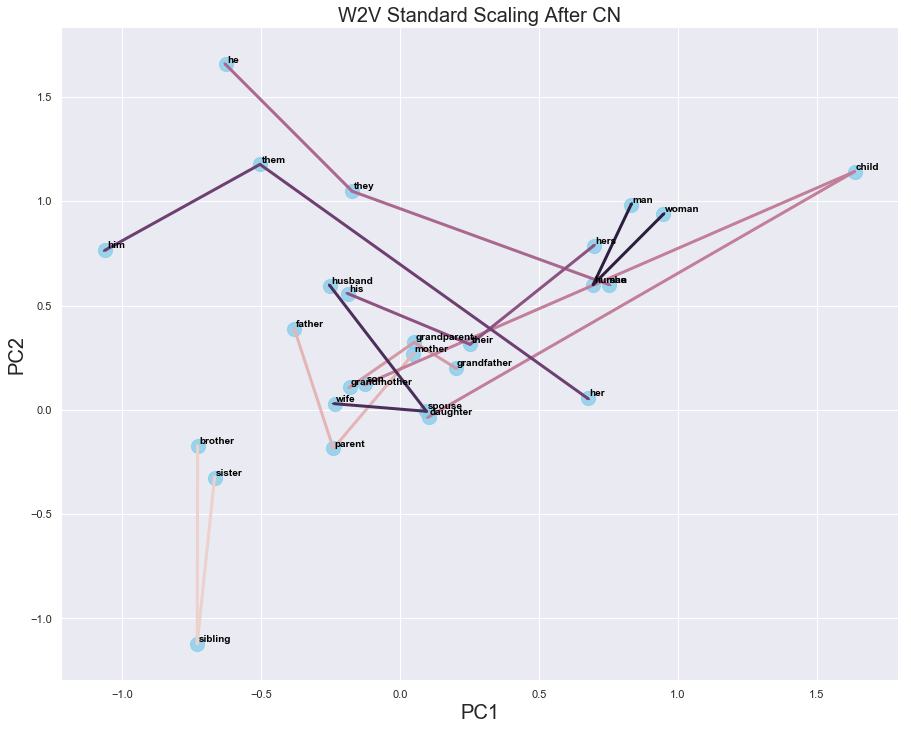

In [246]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(std_scale_w2v_embd_cn) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('W2V Standard Scaling After CN', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [247]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9970640024624139, 0.6923414825650573, 0.1332866440352093, 0.9916294474123848, 0.8886810719012017, 0.24701202852937973, 0.1742850915814786, 0.5921030107356527, 0.9551667504302932]


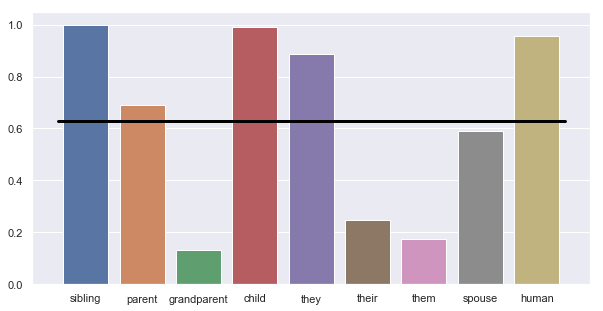

In [248]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

Text(0, 0.5, 'PC2')

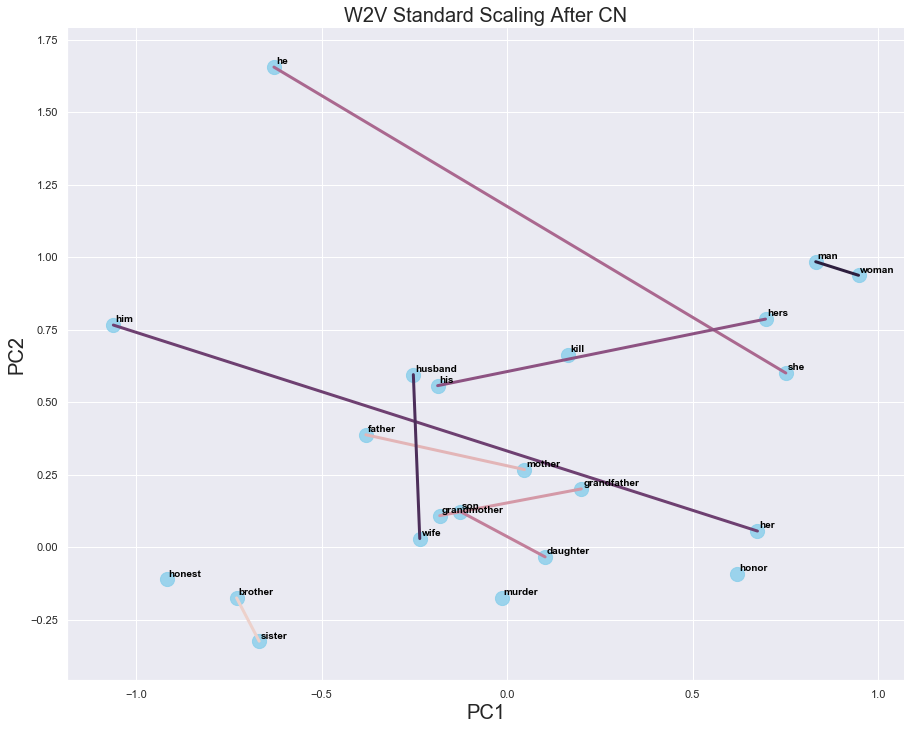

In [249]:
# basic plot
PC = PCA(n_components=2).fit_transform(std_scale_w2v_embd_cn) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling After CN', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [250]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [1.0681807611448741, 1.2248114973700208, 0.7720423278436939, 0.9400121224964515]
female:  [1.2496726556110445, 0.7796897990768076, 0.7295246560845111, 0.7121097394593672]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


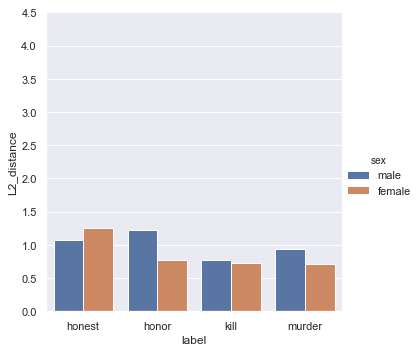

In [251]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 4.5))

### - Glove

##### Compare to neutral words 

In [252]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
std_scale_glove_embd = scaler.fit_transform(glove_embd)

Text(0, 0.5, 'PC2')

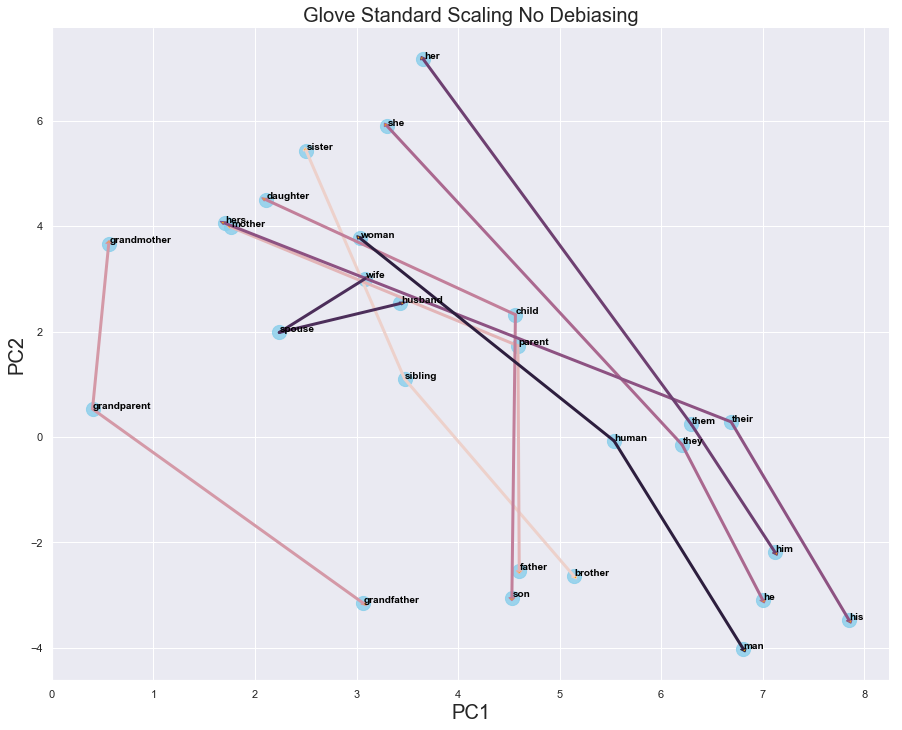

In [253]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(std_scale_glove_embd) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.06, head_length=0.06, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.06, head_length=0.06, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('Glove Standard Scaling No Debiasing', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [254]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9803020126972171, 0.6253753312885747, 0.7793310007225477, 0.6591172500574161, 0.9830104068649584, 0.8115962423671268, 0.9993273569046753, 0.9020986190529625, 0.965087178360627]


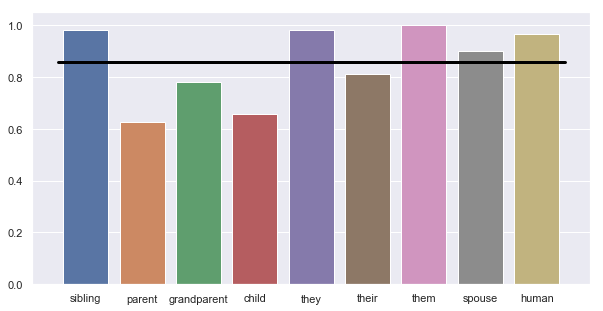

In [255]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

In [256]:
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
std_scale_glove_target_embd = scaler.fit_transform(glove_target_embd)

Text(0, 0.5, 'PC2')

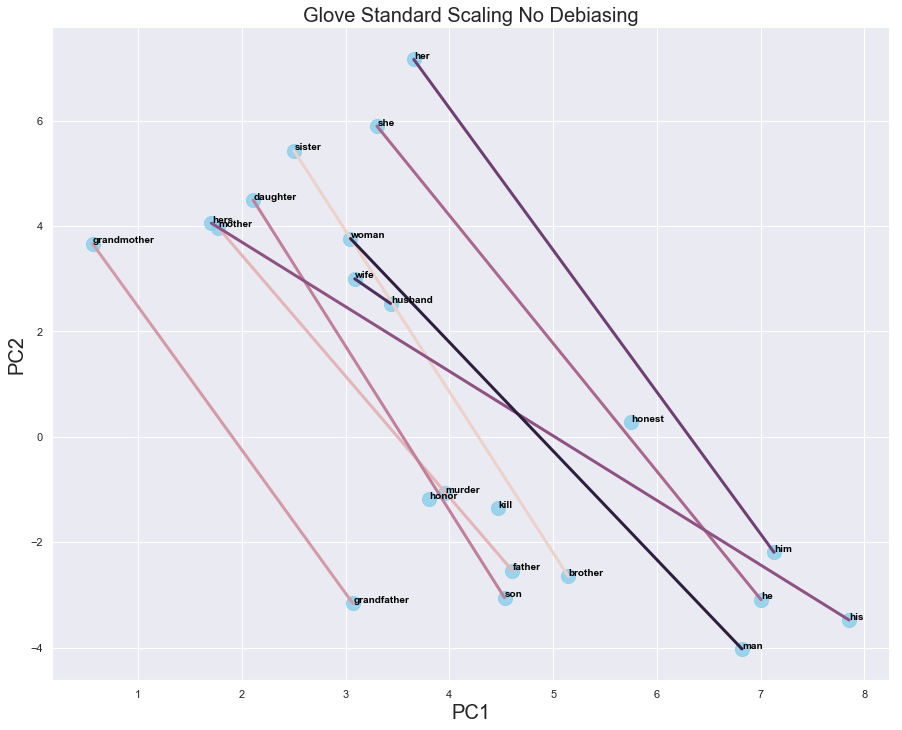

In [257]:
# basic plot
PC = PCA(n_components=2).fit_transform(std_scale_glove_target_embd) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove Standard Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [258]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [3.5906219482421875, 3.0504651599460177, 2.6723165379630194, 3.0293684800465903]
female:  [5.598151048024495, 6.034481790330675, 6.398167769114177, 5.971848169962565]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


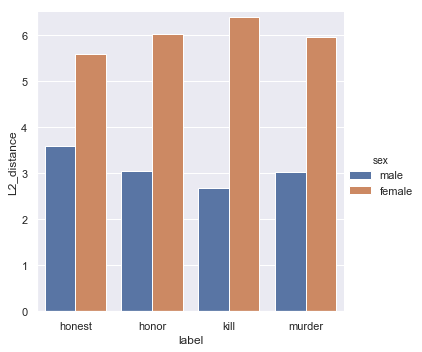

In [259]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 6.5))


##### Apply CN 

In [238]:
std_scale_glove_embd_cn = post_process_cn(std_scale_glove_embd, glove_labels)

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

Text(0, 0.5, 'PC2')

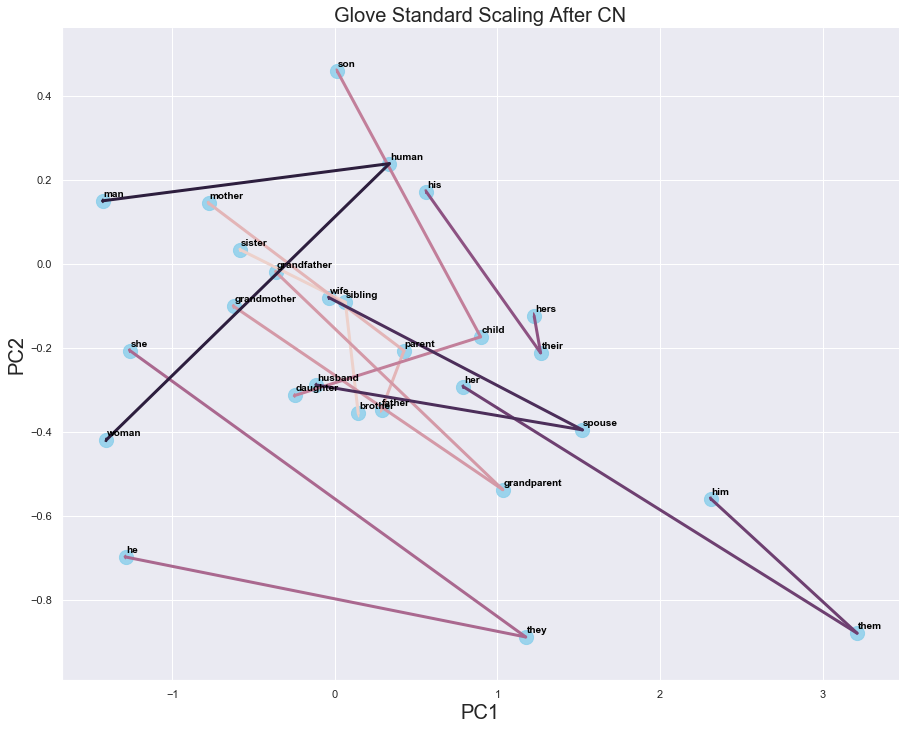

In [260]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(std_scale_glove_embd_cn) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('Glove Standard Scaling After CN', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [261]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.46382770962523645, 0.4747073050895641, 0.9952459274451093, 0.7358998526142227, 0.9808752097098956, 0.7988893541949622, 0.9945888137828907, 0.991013681841629, 0.9520117364115017]


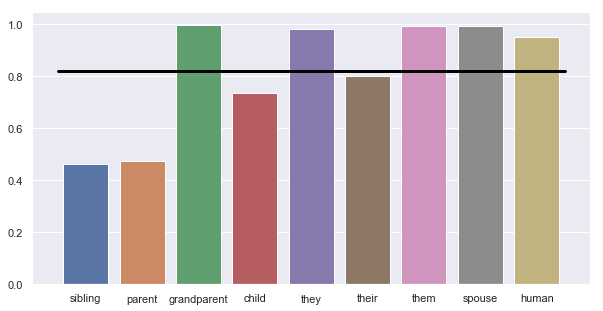

In [262]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

Text(0, 0.5, 'PC2')

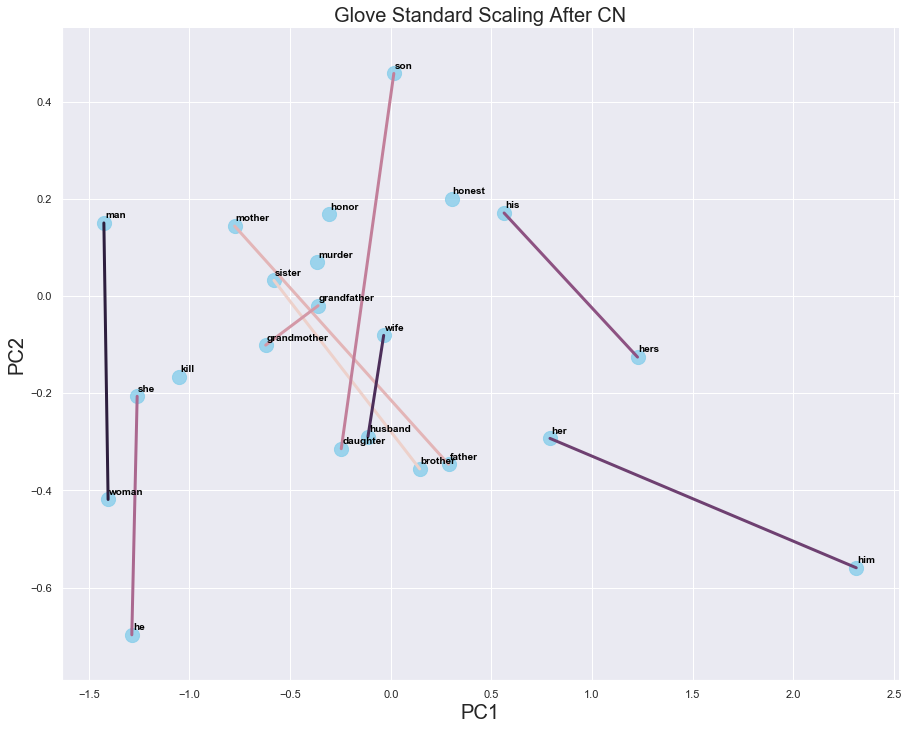

In [263]:
# basic plot
PC = PCA(n_components=2).fit_transform(std_scale_glove_embd_cn) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove Standard Scaling After CN', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [264]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.9796651589407348, 0.95772545212227, 1.283618644105522, 0.9397061395159406]
female:  [1.0272760868414494, 0.784887901344927, 0.8852663201388383, 0.7340845288028973]
target labels:  ['honest', 'honor', 'kill', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


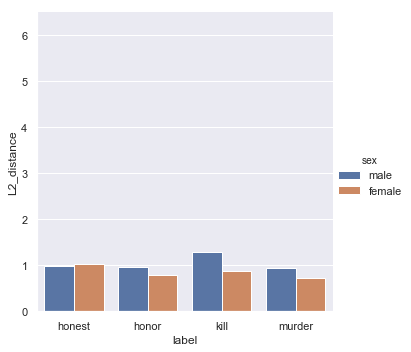

In [265]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 6.5))


   ## 3. Unit-length Scale 

##### Compare to neutral words 

In [22]:
w2v_embd.shape

(7125, 300)

In [24]:
unit_w2v_embd = []; 
for i in range(w2v_embd.shape[0]): 
    unit_embd = w2v_embd[i,:] / np.linalg.norm(w2v_embd[i,:])
    unit_w2v_embd.append(unit_embd)

unit_w2v_embd = np.asarray(unit_w2v_embd)
unit_w2v_embd.shape


(7125, 300)

Text(0, 0.5, 'PC2')

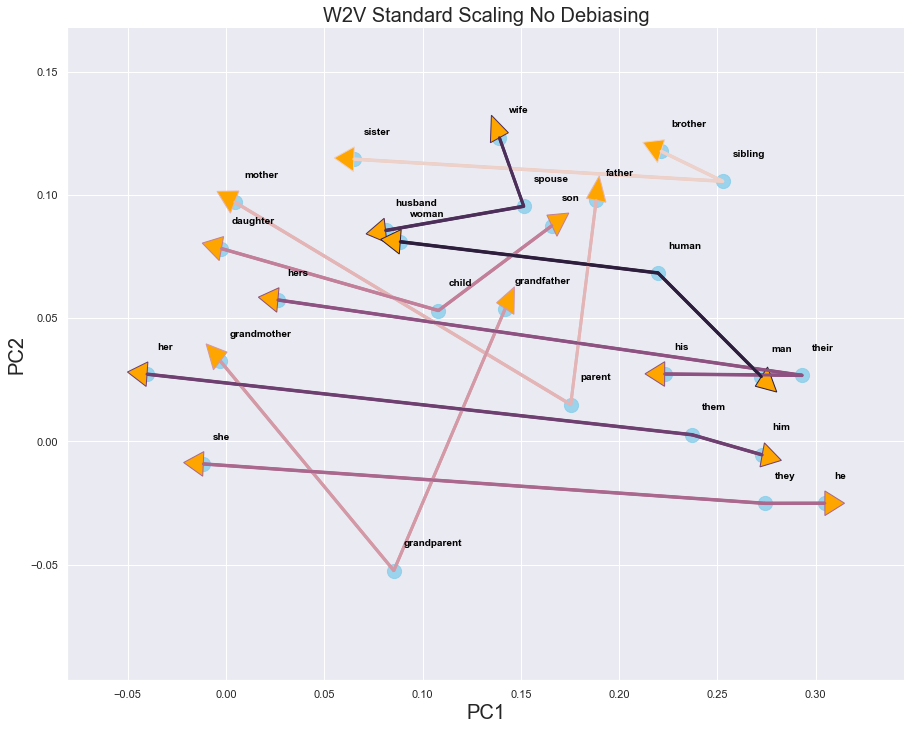

In [25]:
# basic plot
PC = PCA(n_components=2).fit_transform(unit_w2v_embd) 
data = PC[0:len(chk_terms), :]

# sns.set_style('ticks')
p1 = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)

In [26]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9484068664592549, 0.2889404621421729, 0.27375445101945767, 0.7233378297629617, 0.9983779414853755, 0.994333763281742, 0.9906832861334803, 0.2762431189519707, 0.8371521170924844]


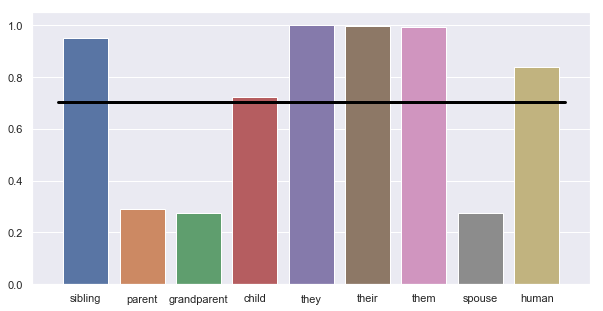

In [27]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

In [28]:
unit_w2v_target_embd = []; 
for i in range(w2v_target_embd.shape[0]): 
    unit_embd = w2v_target_embd[i,:] / np.linalg.norm(w2v_target_embd[i,:])
    unit_w2v_target_embd.append(unit_embd)

unit_w2v_target_embd = np.asarray(unit_w2v_target_embd)
unit_w2v_target_embd.shape

(7129, 300)

Text(0, 0.5, 'PC2')

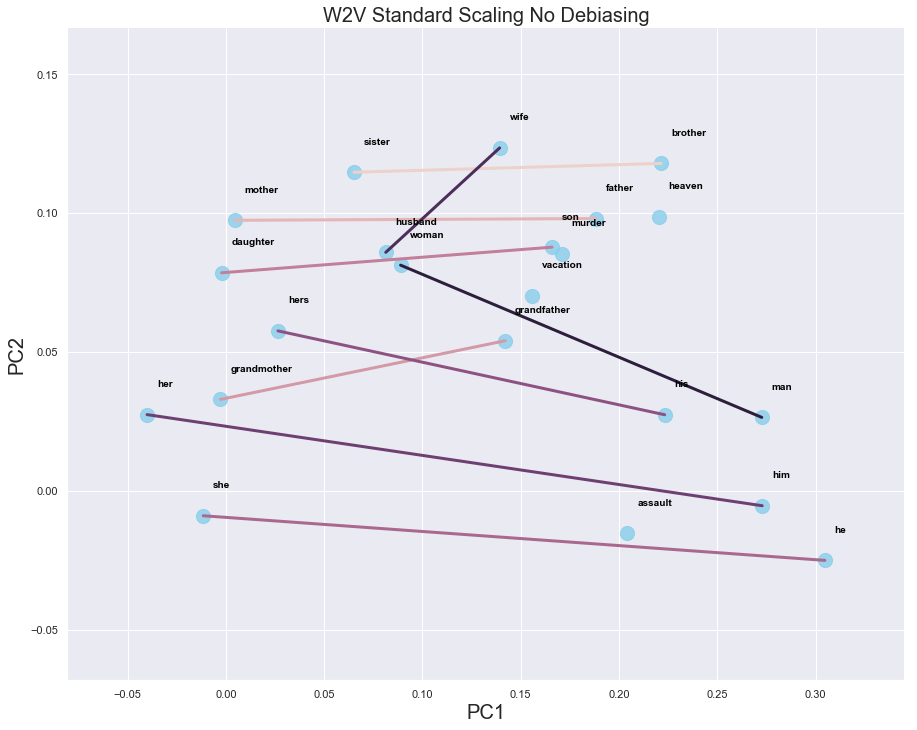

In [29]:
# basic plot
PC = PCA(n_components=2).fit_transform(unit_w2v_target_embd) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [30]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.08477745080987613, 0.08476253764496909, 0.10095417292581664, 0.08054758898086017]
female:  [0.1964135757750935, 0.13490449595782492, 0.20216035180621678, 0.14827582322888905]
target labels:  ['heaven', 'vacation', 'assault', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


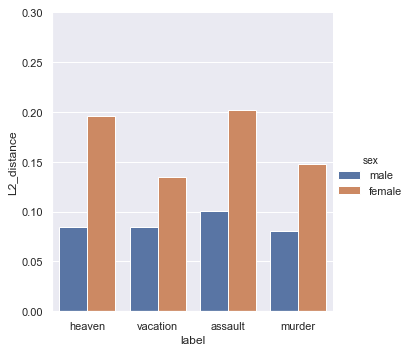

In [34]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 0.3))

##### Apply CN 

In [35]:
unit_w2v_embd_cn = post_process_cn(unit_w2v_embd, w2v_labels)

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

Text(0, 0.5, 'PC2')

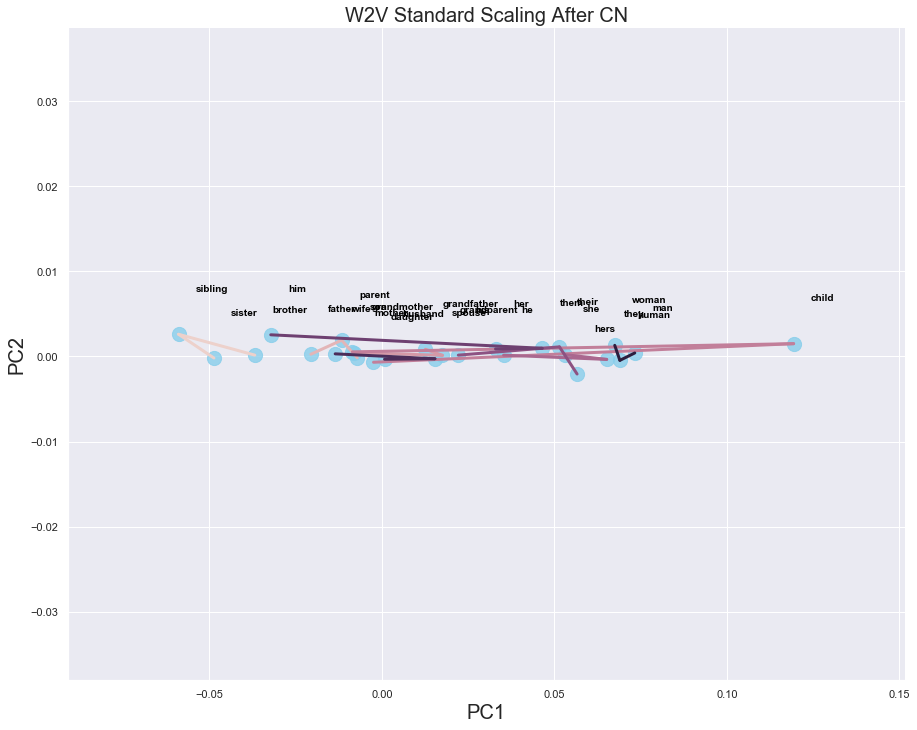

In [54]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(unit_w2v_embd_cn) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.005, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
 
# titles 
p1_cn.set_title('W2V Standard Scaling After CN', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [45]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9881771438702731, 0.8428765923126054, 0.9942589409174053, 0.999942065055555, 0.9996561506823401, 0.8979493027217873, 0.9972327765711405, 0.9962095674448489, 0.38010797559996307]


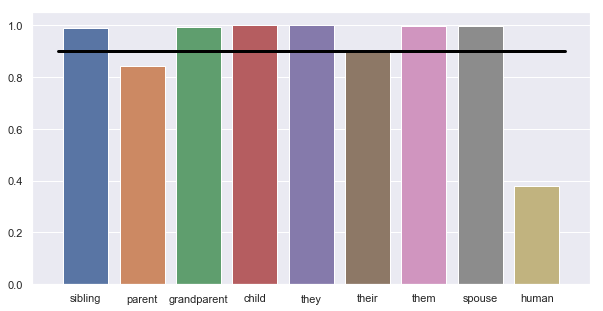

In [46]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)

##### Compare to target words 

Text(0, 0.5, 'PC2')

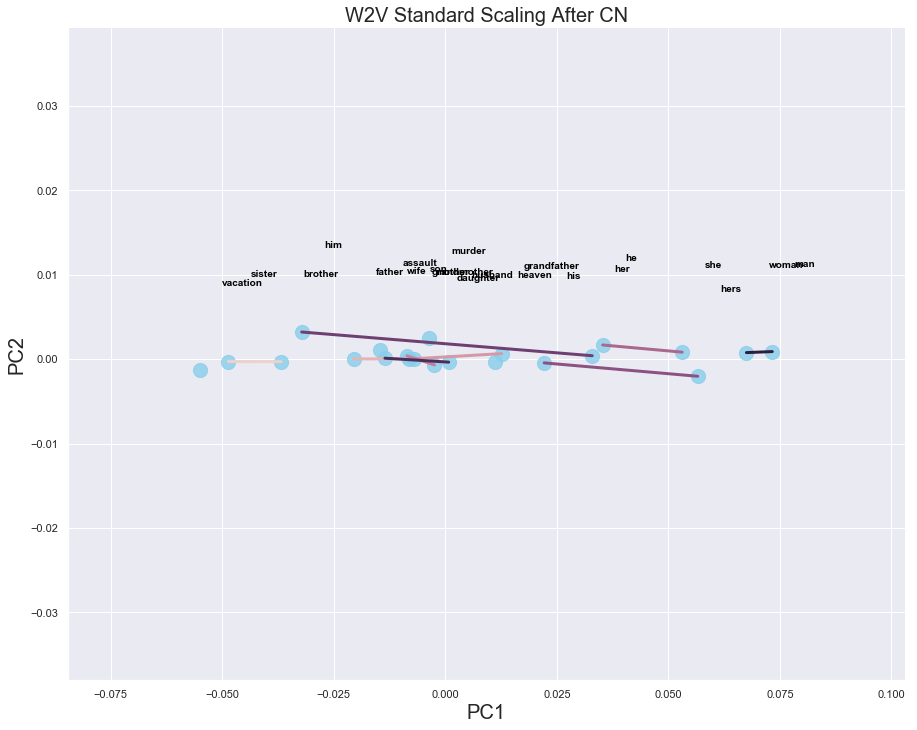

In [50]:
# basic plot
PC = PCA(n_components=2).fit_transform(unit_w2v_embd_cn) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('W2V Standard Scaling After CN', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [55]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.028035519023978397, 0.06018417667312629, 0.029930909546345735, 0.027518192994616855]
female:  [0.03345082031089073, 0.0695069733475609, 0.03674698937550393, 0.032540813445572164]
target labels:  ['heaven', 'vacation', 'assault', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


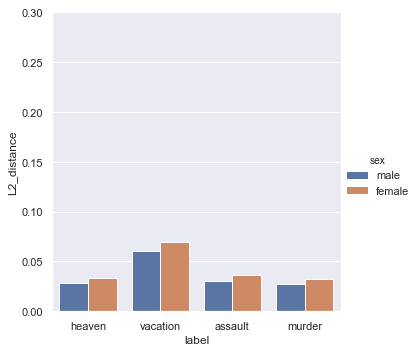

In [58]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 0.3))

### - Glove

##### Compare to neutral words 

In [59]:
unit_glove_embd = []; 
for i in range(glove_embd.shape[0]): 
    unit_embd = glove_embd[i,:] / np.linalg.norm(glove_embd[i,:])
    unit_glove_embd.append(unit_embd)

unit_glove_embd = np.asarray(unit_glove_embd)
unit_glove_embd.shape


(7278, 300)

Text(0, 0.5, 'PC2')

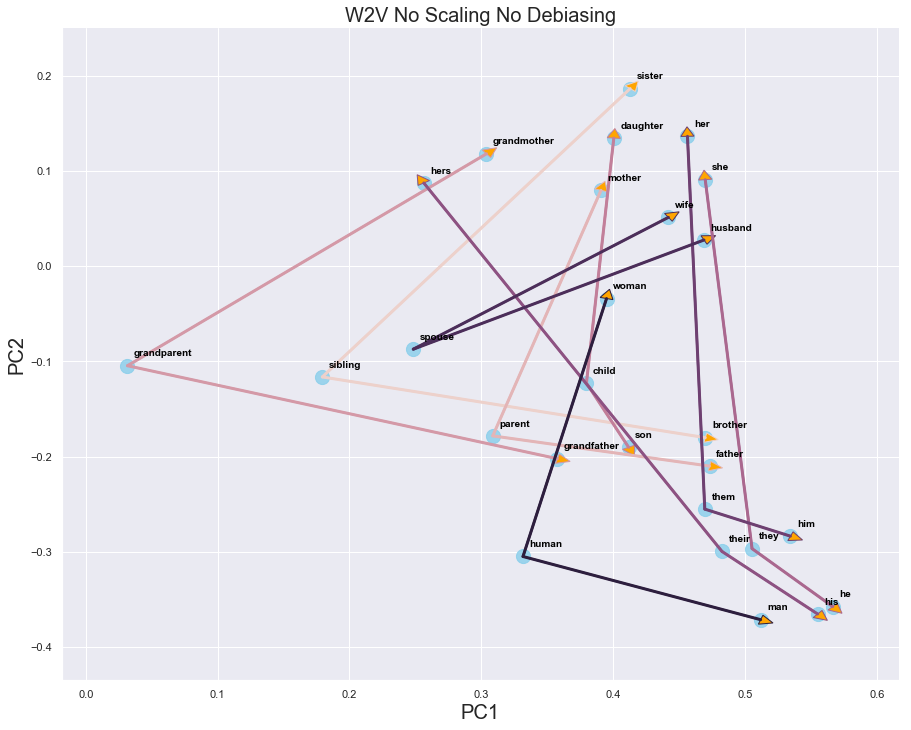

In [61]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(unit_glove_embd) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.01, head_length=0.01, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('W2V No Scaling No Debiasing', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [62]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.4268293245172981, 0.11736797725682273, 0.5601463663976451, 0.8662623710824646, 0.7671171880402259, 0.9535160701629976, 0.4313257018970282, 0.9900122198416638, 0.12273265580225104]


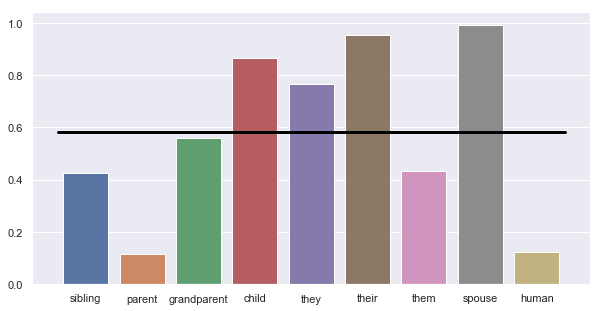

In [63]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

In [64]:
unit_glove_target_embd = [] 

for i in range(glove_target_embd.shape[0]): 
    unit_embd = glove_target_embd[i,:] / np.linalg.norm(glove_target_embd[i,:])
    unit_glove_target_embd.append(unit_embd)

unit_glove_target_embd = np.asarray(unit_glove_target_embd)
unit_glove_target_embd.shape

(7282, 300)

Text(0, 0.5, 'PC2')

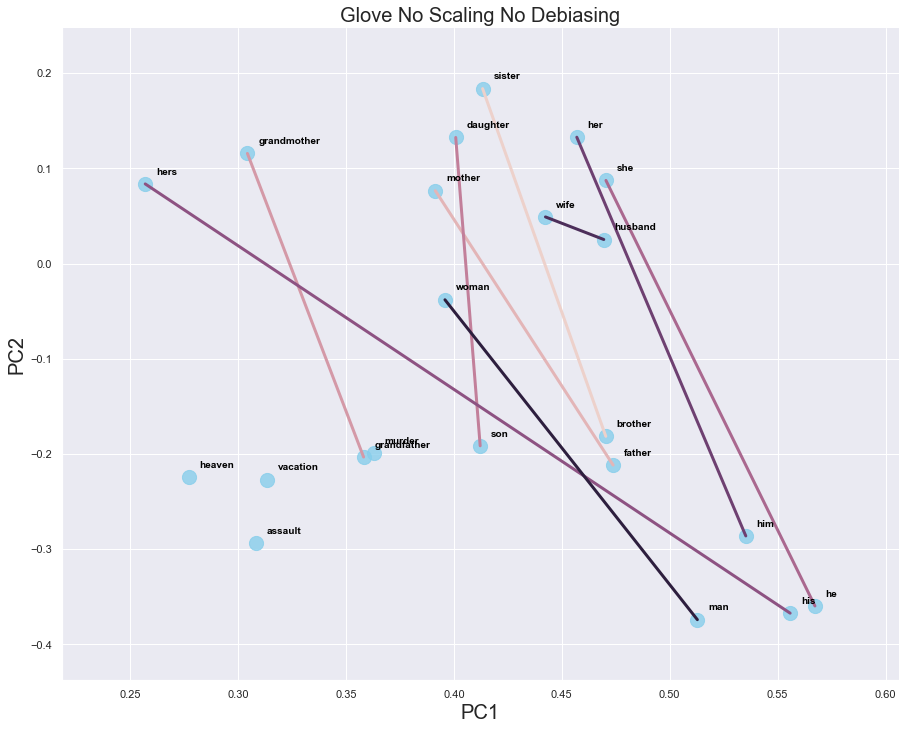

In [65]:
# basic plot
PC = PCA(n_components=2).fit_transform(unit_glove_target_embd) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.005, data[line, 1]+0.01, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove No Scaling No Debiasing', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [66]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.23458472142616907, 0.2024081763294008, 0.217789056400458, 0.16269778299869764]
female:  [0.34299080901675755, 0.33484936422771877, 0.3994911147488488, 0.2991308818260829]
target labels:  ['heaven', 'vacation', 'assault', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


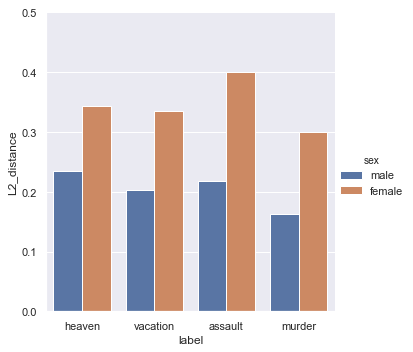

In [68]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 0.5))

##### Apply CN 

In [69]:
unit_glove_embd_cn = post_process_cn(unit_glove_embd, glove_labels)

starting...
R done
C done
negC done
newX done


##### Compare to neutral words 

Text(0, 0.5, 'PC2')

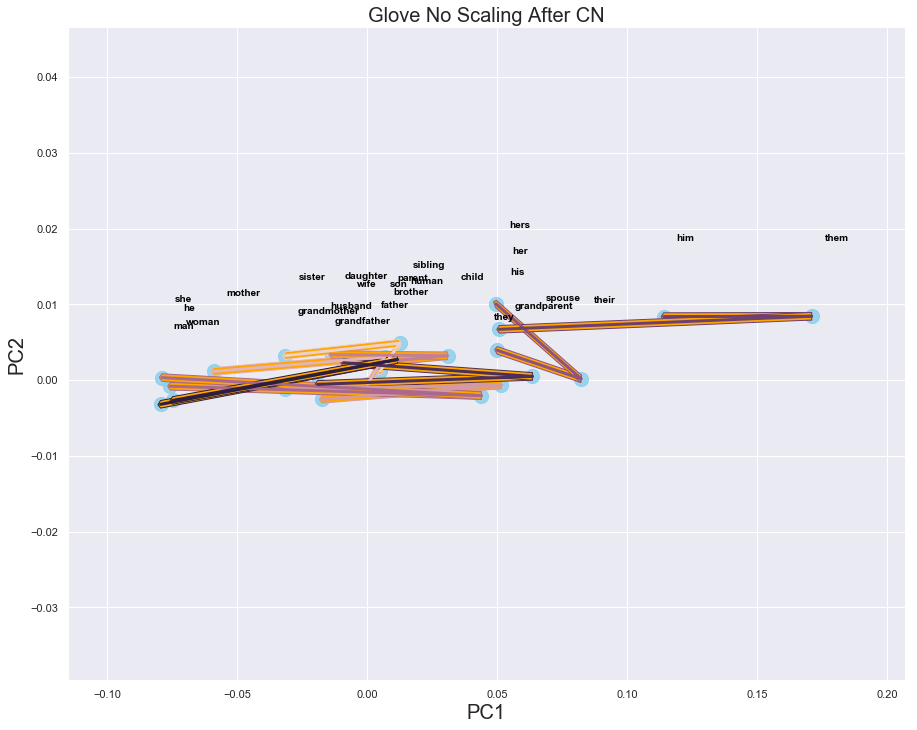

In [71]:
# basic plot
PC_cn = PCA(n_components=2).fit_transform(unit_glove_embd_cn) 
data = PC_cn[0:len(chk_terms), :]

# sns.set_style('ticks')
p1_cn = sns.regplot(x=data[:,0], y=data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1_cn.figure.set_size_inches(15, 12)
sns.despine()

# add annotations one by one with a loop
for line in range(len(chk_terms)):
     p1_cn.text(data[line, 0] +0.005, data[line, 1]+0.01, chk_terms[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1_cn.plot([data[3*i+2,0], data[3*i,0]], [data[3*i+2,1], data[3*i,1]], linewidth=3, color=colors[i])
    p1_cn.plot([data[3*i+2,0], data[3*i+1,0]], [data[3*i+2,1], data[3*i+1,1]], linewidth=3, color=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i,0] - data[3*i+2,0], data[3*i,1] - data[3*i+2,1], 
             head_width=0.001, head_length=0.001, 
             fc='orange', ec=colors[i])
    
    p1_cn.arrow(data[3*i+2,0], data[3*i+2,1], 
             data[3*i+1,0] - data[3*i+2,0], data[3*i+1,1] - data[3*i+2,1], 
             head_width=0.001, head_length=0.001, 
             fc='orange', ec=colors[i])
 
# titles 
p1_cn.set_title('Glove No Scaling After CN', fontsize=20)
p1_cn.set_xlabel('PC1', fontsize=20) 
p1_cn.set_ylabel('PC2', fontsize=20)


In [72]:
cosine = [] 
for i in range(L): 
    v1 = [data[3*i,0] - data[3*i+2,0], 
          data[3*i,1] - data[3*i+2,1]]
    v2 = [data[3*i+1,0] - data[3*i+2,0], 
          data[3*i+1,1] - data[3*i+2,1]]
    cos = dotproduct(v1, v2)/length(v1)/length(v2)
    cosine.append(abs(cos))

print('cosine similarities: ', cosine)

cosine similarities:  [0.9160232187580588, 0.8909704408401187, 0.9997793083187253, 0.999368592834408, 0.9999589585498455, 0.9843424628394697, 0.9999074835694536, 0.9992957846827834, 0.9999970831029454]


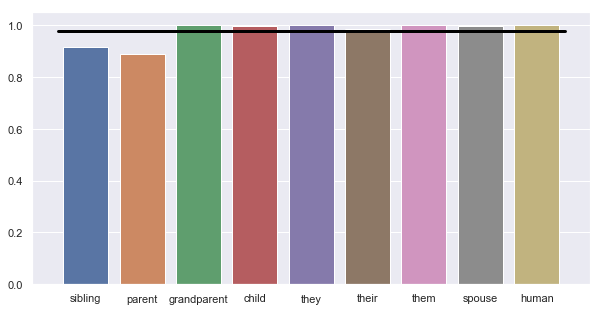

In [73]:
ax = sns.barplot(x=chk_neut_terms, y=cosine)
ax.plot([-0.5, 8.5], [np.average(cosine), np.average(cosine)], linewidth=3, color='black')
ax.figure.set_size_inches(10, 5)


##### Compare to target words 

Text(0, 0.5, 'PC2')

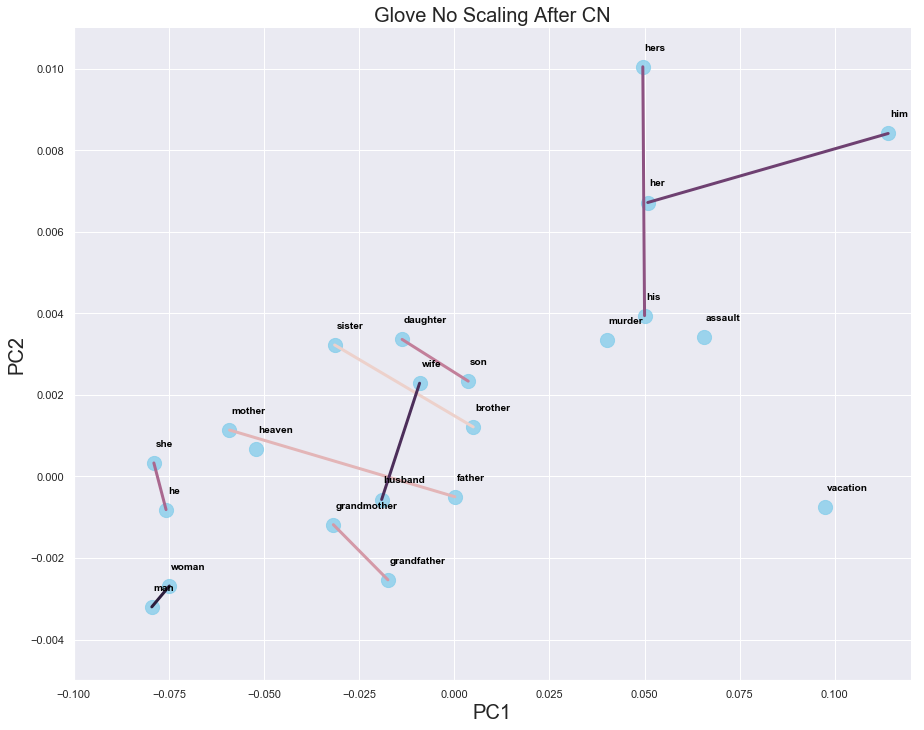

In [81]:
# basic plot
PC = PCA(n_components=2).fit_transform(unit_glove_embd_cn) 
data = np.concatenate((PC[0:len(chk_terms), :], PC[-1*(len(p_unp_list)):, :]), axis = 0) 
# remove the neutral terms 
idx = [2,5,8,11,14,17,20,23,26]
here_data = np.delete(data, idx, axis = 0)
here_labels = chk_terms + p_unp_list

# sns.set_style('ticks')
p1 = sns.regplot(x=here_data[:,0], y=here_data[:,1], fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})
p1.figure.set_size_inches(15, 12)
p1.set(ylim=(-0.005, 0.011))
p1.set(xlim=(-0.1, 0.12))
sns.despine()

# add annotations one by one with a loop
for line in range(len(here_labels)):
    # exclude neutral terms 
    if (line < len(chk_terms)) and ((line-2) % 3 == 0): 
        pass 
    else: 
        p1.text(data[line, 0] +0.0005, data[line, 1]+0.0004, here_labels[line], 
                horizontalalignment='left', size='medium', color='black', weight='semibold')

# draw line among pairs 
colors = sns.cubehelix_palette(9)
for i in range(L): 
    p1.plot([data[3*i+1,0], data[3*i,0]], [data[3*i+1,1], data[3*i,1]], linewidth=3, color=colors[i])
 
# titles 
p1.set_title('Glove No Scaling After CN', fontsize=20)
p1.set_xlabel('PC1', fontsize=20) 
p1.set_ylabel('PC2', fontsize=20)


In [82]:
# euclidean distance of the target words with the gender words 
print(here_data.shape)
# m, f, m, f, etc. 

male_holder = [] 
female_holder = [] 

for j in range(-1*len(p_unp_list),0): # loop thru target words 
    female_dist = 0 
    male_dist = 0 
    for i in range(2*len(chk_male_terms)): # loop thru each gender words 
        if i % 2 == 0: # is male 
            male_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
        else: 
            female_dist += np.linalg.norm(here_data[i,:] - here_data[j,:])
    
    avg_male_dist = male_dist / len(chk_male_terms)
    avg_female_dist = female_dist / len(chk_female_terms)
    male_holder.append(avg_male_dist)
    female_holder.append(avg_female_dist)

print('male: ', male_holder)
print('female: ', female_holder)
print('target labels: ', p_unp_list)

(22, 2)
male:  [0.0614431275181465, 0.10350153019951677, 0.07863161311660104, 0.06097936095814935]
female:  [0.042763648486986404, 0.11969200633143738, 0.08796131577322014, 0.06700919306925246]
target labels:  ['heaven', 'vacation', 'assault', 'murder']


/Users/lisazhao/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


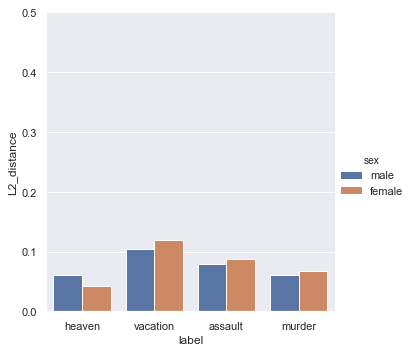

In [84]:
df = pd.DataFrame(male_holder + female_holder)
df = pd.DataFrame({'L2_distance':male_holder + female_holder, 
                   'sex': ['male', 'male', 'male', 'male', 'female' , 'female' , 'female' , 'female'], 
                   'label': p_unp_list + p_unp_list
                  })
g = sns.factorplot(x='label', y='L2_distance', hue='sex', data = df, kind='bar')
g.set(ylim=(0, 0.5))
